In [3]:
import os
import tqdm
from collections import defaultdict
from sklearn.metrics import cohen_kappa_score

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
import torch
import torch.nn as nn
import torchvision.transforms as T
import torch.nn.functional as F
import torch.optim as optim

import torchio as tio
import torchvision
import torchvision.models

import optuna
from optuna.trial import TrialState

from losses import get_loss
from datasets import CMRxMOTION2D

In [4]:
%load_ext autoreload
%autoreload 2

In [14]:
STUDY_NAME = "EB5_RANDOMAFFINE_CENTRALCROP_MA_FL_CK_PC"
# MODEL_NAME = "ResNet50"
MODEL_NAME = "EfficientNet_B5"
MODE_3D_2D = '2D'                                ### 3D/2D CONFIG? WILL AFFECT DATALOADER AND NETWORK ARCHITECTURE
PIDS_VAL = [3, 9, 14, 19]                        ### IDENTIFY THE PIDS FOR VALIDATION
PIDS_TR = set(range(1, 21))                      ### THE REST OF PIDS'LL BE USED FOR TRAINING 
for pid in PIDS_VAL:
    PIDS_TR.remove(pid)
PIDS_TR = list(PIDS_TR)
DATA_PATH = "../datasets/cmrxmotion/train_aug/"    ### TO BE RECONFIGURED
DEBUG = True                                    ### SWITCHING TO DEBUG MODE

DEVICE = torch.device("cuda")
BATCH_SIZE = 16
CLASSES = 3
DIR = os.getcwd()
EPOCHS = 10
TRAIN_VAL_RATIO = 0.8
LOSS_NAME = "FocalLoss"

if MODE_3D_2D == '2D':
    EPOCHS = 75


In [15]:
if DEBUG:
    if MODE_3D_2D == "3D":
        pass
    elif MODE_3D_2D == "2D":
        transforms_tr = T.Compose([
            T.RandomAffine(degrees=120, translate=(0.,0.1), scale=(0.85, 1.15)),
            T.CenterCrop(256),
            T.ToTensor(),
            T.ConvertImageDtype(torch.float),
        ])
        transforms_val = T.Compose([
            T.CenterCrop(256),
            T.ToTensor(),
            T.ConvertImageDtype(torch.float),
        ])

        tio_transforms = [
            # tio.RandomMotion(degrees=3, translation=1, num_transforms=1),
            tio.RescaleIntensity(out_min_max=(0, 1), percentiles=(0.5, 99.5)),
        ]

        train_dataset = CMRxMOTION2D(DATA_PATH, mode='train', pids=PIDS_TR, transforms=transforms_tr, tio_transforms=tio_transforms)
        val_dataset = CMRxMOTION2D(DATA_PATH, mode='val', pids=PIDS_VAL, transforms=transforms_val, tio_transforms=tio_transforms)


In [16]:
# class CMRxMOTION(object):
#     def __init__(self, dataset_path, split=True, mode='train', input_mode='2D'):
#         self.sample_path = os.path.join(dataset_path, "data")
#         self.label_path = os.path.join(dataset_path, "IQA.csv")
#         self.split = split
#         self.mode = mode
#         self.input_mode = input_mode

#         self.csv = pd.read_csv(self.label_path)
#         self.n_samples = len(self.csv)

#         self.compose_dataset()

#     def compose_dataset(self):
#         content = self.csv["Image"]
#         samples = []

#         if self.split:
#             if self.mode == 'train':
#                 # min_limit = 0
#                 # max_limit = int(self.n_samples * TRAIN_VAL_RATIO)
#                 min_limit = 0
#                 max_limit = 1
#             elif self.mode == 'val':
#                 # min_limit = int(self.n_samples * TRAIN_VAL_RATIO) + 1
#                 # max_limit = self.n_samples
#                 min_limit = 1
#                 max_limit = 2
#         else:
#             min_limit = 0
#             max_limit = self.n_samples
#         self.n_samples = max_limit - min_limit

#         for d in range(min_limit, max_limit):
#             img_name, label = self.csv["Image"][d], self.csv["Label"][d] - 1
#             pid, phase = img_name[:-3], img_name[-2:]

#             img_fullpath = os.path.join(self.sample_path, pid, img_name + ".nii.gz")
#             img = tio.ScalarImage(img_fullpath)

#             segm = None
#             if label != 3:
#                 segm_fullpath = os.path.join(self.sample_path, pid, img_name + ".nii.gz")
#                 segm = tio.ScalarImage(segm_fullpath)

#             subject = tio.Subject(img=img, segm=segm, label=label)

#             samples.append(subject)

#         transforms = [
#             tio.RescaleIntensity(out_min_max=(0, 1)),
#             tio.CropOrPad((256, 256, 12)),
#             # tio.RandomAffine(),
#         ]

#         transform = tio.Compose(transforms)
#         self.samples = tio.SubjectsDataset(samples, transform=transform)

#     def __getitem__(self, idx):
#         img, label = self.samples[idx]["img"], self.samples[idx]["label"]

#         if self.input_mode == "2D":
#             d = img.shape[-1]
#             rand_d = np.random.randint(0, d-1)
#             rand_d2 = np.random.randint(0, d-1)
#             rand_d3 = np.random.randint(0, d-1)
#             concat_img = torch.concat([img.data[:,:,:,rand_d], img.data[:,:,:,rand_d], img.data[:,:,:,rand_d]])
#             return concat_img, label
#         return img.data, label

#     def __len__(self):
#         return self.n_samples


# if MODE_3D_2D == "3D":
#     transforms = None
#     train_dataset = CMRxMOTION(DATA_PATH, mode='train')
#     val_dataset = CMRxMOTION(DATA_PATH, mode='val')
# elif MODE_3D_2D == "2D":
#     transforms = T.Compose([
#         T.CenterCrop(256),
#         T.ToTensor(),
#         T.ConvertImageDtype(torch.float),
#     ])
#     train_dataset = CMRxMOTION2D(DATA_PATH, mode='train', transforms=transforms)
#     val_dataset = CMRxMOTION2D(DATA_PATH, mode='val', transforms=transforms)


# Preparing the CMRxMOTION Data Loaders
if DEBUG:
    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=4
    )
    val_loader = torch.utils.data.DataLoader(
        val_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=4
    )

In [17]:
def show(imgs):
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False, figsize=(16, 16))
    for i, img in enumerate(imgs):
        img = T.ToPILImage()(img.to('cpu'))
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

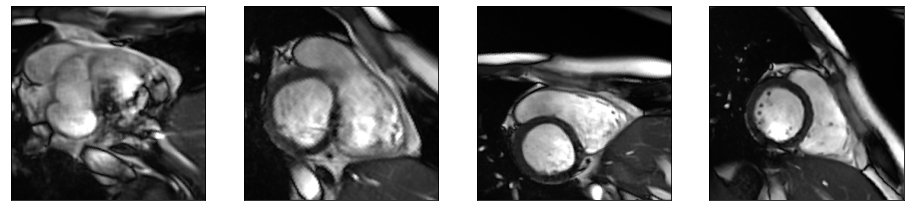

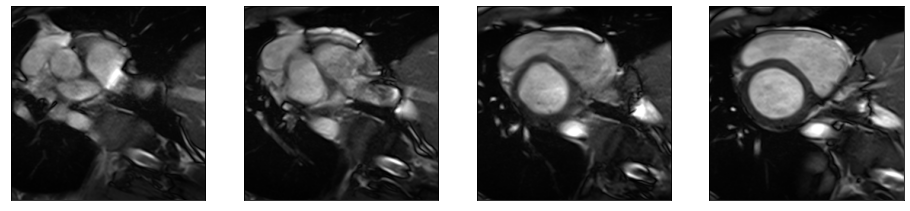

In [18]:
# Samples from the train and the val splits
if DEBUG:
    show([(train_dataset.__getitem__(d))[0] for d in range(0, 4)])
    show([(val_dataset.__getitem__(d))[0] for d in range(0, 4)])


In [19]:
def train_loop(model, train_loader, criterion, optimizer):
    model.train()
    correct = 0
    for batch_idx, (data, target, pid, phase, d, _) in (enumerate(train_loader)):
        # # Limiting training data for faster epochs.
        # if batch_idx * BATCH_SIZE >= N_TRAIN_EXAMPLES:
        #     break

        data, target = data.to(DEVICE), target.to(DEVICE)

        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()

        accuracy = correct / len(train_loader.dataset)
        loss.backward()
        optimizer.step()

    return accuracy



def val_loop(model, val_loader, epoch, trial):
    model.eval()
    
    correct = 0
    correct_3d = 0

    all_votes = defaultdict(lambda: [0, 0, 0])
    targets = defaultdict(lambda: -1)

    preds = []
    gt = []
    
    with torch.no_grad():
        for batch_idx, (data, target, pid, phase, depth, _) in (enumerate(val_loader)):
            data, target = data.to(DEVICE), target.to(DEVICE)
            output = model(data)
            # Get the index of the max log-probability.
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

            # TODO: Max importance for mid, min importance
            # for apex and basal slices for final decision
            for i, (id, ph, d) in enumerate(zip(pid, phase, depth)):
                filename = "-".join([id, ph])
                all_votes[filename][pred[i]] += 1
                targets[filename] = target[i]

        for fn, vote in all_votes.items():
            final_pred = torch.argmax(torch.Tensor([vote]), dim=1)
            correct_3d += final_pred.eq(targets[fn].view_as(final_pred).sum().item())
            preds.append(final_pred.cpu().item())
            gt.append(targets[fn].item())
            
        accuracy = correct / len(val_loader.dataset)
        accuracy_patient = torch.Tensor(preds).eq(torch.Tensor(gt)).sum().item() / len(gt)

        ck = cohen_kappa_score(preds, gt)

        return accuracy, accuracy_patient, ck

In [25]:
def get_model():
    weights_name = MODEL_NAME + "_Weights"
    weights = getattr(torchvision.models, weights_name)
    model_ft = getattr(torchvision.models, MODEL_NAME.lower())(weights=weights.DEFAULT)
    # model_ft = resnet50(weights=torchvision.models.ResNet50_Weights.DEFAULT)
    if "resnet" in MODEL_NAME.lower():
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, CLASSES)
    if "efficientnet" in MODEL_NAME.lower():
        num_ftrs = model_ft.classifier[1].in_features
        model_ft.classifier[1] = nn.Linear(num_ftrs, CLASSES)
    return model_ft

def objective(trial, train_loader, val_loader, optimizer_name, lr, isNotCV=True):

    # Model Initializer
    model = get_model().to(DEVICE)
    if LOSS_NAME == "FocalLoss":
        alpha = trial.suggest_float("alpha", 0.2, 0.3, log=True)
        gamma = trial.suggest_categorical("gamma", [1.5, 2., 2.5])
        loss_args = {"alpha": alpha, "gamma": gamma, "reduction": "mean"}
    else:
        loss_args = None
    criterion = get_loss(LOSS_NAME, **loss_args)
    optimizer = getattr(optim, optimizer_name)(model.parameters(), lr=lr)

    # Training and Validation of the model.
    for epoch in range(EPOCHS):
        accuracy_tr = train_loop(model, train_loader, criterion, optimizer)
        accuracy, accuracy_patient, ck = val_loop(model, val_loader, epoch, trial)
        print("Train Accuracy at Epoch " + str(epoch) + ": ", str(accuracy_tr))
        print("Val Accuracy at Epoch " + str(epoch) + ": ", str(accuracy))
        print("Val Patientwise Accuracy at Epoch " + str(epoch) + ": ", str(accuracy_patient))
        print("Val Patientwise Cohen's Kappa at Epoch " + str(epoch) + ": ", str(ck))

        if isNotCV:
            # trial.report(accuracy, epoch)
            trial.report(ck, epoch)

            # Handle pruning based on the intermediate value.
            if trial.should_prune():
                raise optuna.exceptions.TrialPruned()

    # return accuracy
    return ck


# Initiate objective for a fixed train/val split
def objective_tr_val(trial):
    # Optimizer preparation
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "RMSprop", "SGD"])
    lr = trial.suggest_float("lr", 1e-5, 1e-3, log=True)
    
    if MODE_3D_2D == "3D":
        pass
    elif MODE_3D_2D == "2D":
        transforms_tr = T.Compose([
            T.CenterCrop(256),
            T.ToTensor(),
            T.ConvertImageDtype(torch.float),
        ])
        transforms_val = T.Compose([
            T.CenterCrop(256),
            T.ToTensor(),
            T.ConvertImageDtype(torch.float),
        ])
        tio_transforms = [
            # tio.RandomMotion(degrees=3, translation=1, num_transforms=1),
            tio.RescaleIntensity(out_min_max=(0, 1), percentiles=(0.5, 99.5)),
        ]

        train_dataset = CMRxMOTION2D(DATA_PATH, mode='train', pids=PIDS_TR, transforms=transforms_tr, tio_transforms=tio_transforms)
        val_dataset = CMRxMOTION2D(DATA_PATH, mode='val', pids=PIDS_VAL, transforms=transforms_val, tio_transforms=tio_transforms)

    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=8,
    )
    valid_loader = torch.utils.data.DataLoader(
        val_dataset,
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=8,
    )

    metric = objective(trial, train_loader, valid_loader, optimizer_name, lr)

    return metric

# Initiate objective for cross validation
def objective_cv(trial):

    # Optimizer preparation
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "RMSprop", "SGD"])
    lr = trial.suggest_float("lr", 1e-5, 1e-1, log=True)

    if MODE_3D_2D == "3D":
        pass
    elif MODE_3D_2D == "2D":
        transforms_tr = T.Compose([
            T.RandomAffine(degrees=10, translate=(0,0.05), scale=(0.9, 1.1)),
            T.CenterCrop(256),
            T.ToTensor(),
            T.ConvertImageDtype(torch.float),
        ])
        transforms_val = T.Compose([
            T.CenterCrop(256),
            T.ToTensor(),
            T.ConvertImageDtype(torch.float),
        ])
        dataset_tr = CMRxMOTION2D(DATA_PATH, split=False, transforms=transforms_tr)
        dataset_val = CMRxMOTION2D(DATA_PATH, split=False, transforms=transforms_val)

    fold = KFold(n_splits=5, shuffle=True, random_state=31)
    scores = []
    for fold_idx, (train_idx, valid_idx) in enumerate(fold.split(range(len(dataset_tr)))):
        train_data = torch.utils.data.Subset(dataset_tr, train_idx)
        valid_data = torch.utils.data.Subset(dataset_val, valid_idx)

        train_loader = torch.utils.data.DataLoader(
            train_data,
            batch_size=BATCH_SIZE,
            shuffle=True,
            num_workers=8,
        )
        valid_loader = torch.utils.data.DataLoader(
            valid_data,
            batch_size=BATCH_SIZE,
            shuffle=True,
            num_workers=8,
        )

        accuracy = objective(trial, train_loader, valid_loader, optimizer_name, lr, isNotCV=False)
        scores.append(accuracy)

    return np.mean(scores)


In [27]:
study = optuna.create_study(direction="maximize", study_name=STUDY_NAME, storage="sqlite:///dbs/{}.db".format(STUDY_NAME))

study.optimize(objective_tr_val, n_trials=50)              # FIXED SET EVALUATION
# study.optimize(objective_cv, n_trials=50)                  # 5-FOLD CV EVAULATION

pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

print("Study statistics: ")
print("  Number of finished trials: ", len(study.trials))
print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))




[I 2022-07-18 04:01:51,282] A new study created in RDB with name: EB5_RANDOMAFFINE_CENTRALCROP_FL_CK_PC


Train Accuracy at Epoch 0:  0.6557971014492754
Val Accuracy at Epoch 0:  0.42
Val Patientwise Accuracy at Epoch 0:  0.375
Val Patientwise Cohen's Kappa at Epoch 0:  0.0
Train Accuracy at Epoch 1:  0.8586956521739131
Val Accuracy at Epoch 1:  0.42
Val Patientwise Accuracy at Epoch 1:  0.375
Val Patientwise Cohen's Kappa at Epoch 1:  0.0
Train Accuracy at Epoch 2:  0.8985507246376812
Val Accuracy at Epoch 2:  0.54
Val Patientwise Accuracy at Epoch 2:  0.46875
Val Patientwise Cohen's Kappa at Epoch 2:  0.11688311688311692


KeyboardInterrupt: 